##### This notebook allows Glen's A to vary to optimize modeled ice thickness by minimizing the quadratic error between observed and modeled ice thickness (following height change corrections and in situ mass balance inversion)

### named MONSTER by M. Zeuner (Mega Organized Numerical Script Transformation Executing Rapidly)

## Imports

In [11]:
%matplotlib inline
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from oggm import utils, workflow, tasks, graphics

import os
import pandas as pd
import salem
import xarray as xr
import oggm
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

import oggm.cfg as cfg # could that cause problems?
import gdal
from PIL import Image as imagery
import datetime

## Select the glacier by setting num to:

- 0 for Kokanee
- 1 for Haig
- 2 for Conrad
- 3 for W. Washmawapta (no DEM correction available)
- 4 for Illecillewaet (not supported in this version of the script due to shapefile reasons)
- 5 for Nordic (not supported in this version of the script due to shapefile reasons)
- 6 for Zillmer


In [12]:
# Here the num variable is set:
num=0
errors_list = []
# A list with all the glacier names
glacier = ['Kokanee', 'Haig', 'Conrad', 'Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']
glacier_lower = ['kokanee', 'haig', 'conrad', 'washmawapta', 'illecillewaet', 'nordic', 'zillmer']
obs_num = [442,387,824,187,820,461,483] #number of grid cells with obs
thick = [48.1, 115.4, 99.7, 69.3, 101.4, 47.6, 67.5]

# Just confirm that the correct one is selected for this run of the script
print('You selected: ' , glacier[num])

You selected:  Kokanee


### File names settings

In [13]:
# list with the names in the Randolf Glacier invetory (according to the glacier names above)
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780']

# list with the names Lidar data (according to the glacier names above)
dem = ['kokanee/20160913_kokanee_dem1_clip_slave.tif', 'haig/20150912_haig_dem_master_clip.tif', 'conrad/20160912_conrad_dem1_clip_slave.tif', 'not_assigned', 
       'illecillewaet/170917_illecillewaet_dem1_clip_slave.tif', 'nordic/20170927_nordic_dem1_clip_slave.tif', 'zillmer/160914_zillmer_dem2.tif']

#products_directory (where the graphs and some numbers are saved for later usage)
products= '/home/pelto/oggm_runs/products_opt/' + glacier[num] + '/'

# moved best value here to avoid iterating over multiple glen's A values 
# best_value = 6.740e-24, 0.774e-24, 8.095e-24, 0.142e-24, 4.050e-24, 13.0e-24, 3.810e-24  
best_value = 4.84e-24, 0.596e-24, 7.381e-24, 0.142e-24, 4.544e-24, 14.627e-24, 3.432e-24
best_value = best_value[num]
# best_value = 5.08e-24  #2.4e-24

count=0
sw = 101.
dfb = np.arange(0.0, 1.0, 0.05) # the exponent of the distance from border mask default=0.25
len(dfb)

19

## A function to run the OGGM using mass-balance correction and (if wished) the Lidar-DEM 

This is also a function that runs the OGGM on the selected glacier and returns a thickness map for it. It uses the mass-balance correction.

In difference to the function above, this version does not use the SRTM DEM to run it but the more precise Lidar DEM which yields results closer to reality.


2019-12-06 17:31:12: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:31:15: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:31:15: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:31:15: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:31:15: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:31:15: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:31:15: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:31:15: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:31:16: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:31:18: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:31:18: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:31:18: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:31:20: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:31:21: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:31:21: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:31:21: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:31:22: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:31:22: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:31:22: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:31:22: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:31:22: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:31:25: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:31:25: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:31:26: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:31:27: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:31:28: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:31:29: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:31:29: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:31:29: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:31:29: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:31:29: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:31:29: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:31:29: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:31:32: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:31:32: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.01758901967456158
corrected quadratic error is:  89071.8445294153
ME: 1.5420428724849924
MAE: 11.333442068747265


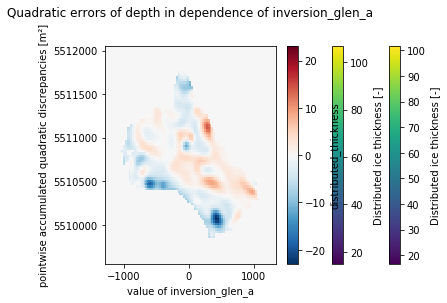

2019-12-06 17:31:33: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 11.333442068747265 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.07
smoothing window (m): 101.0


2019-12-06 17:31:35: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:31:35: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:31:36: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:31:36: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:31:36: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:31:36: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:31:36: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:31:36: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:31:36: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:31:37

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:31:38: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:31:38: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:31:39: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:31:42: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:31:42: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:31:42: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:31:42: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:31:42: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:31:42: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:31:42: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:31:43: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:31:45: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:31:45: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:31:45: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:31:46: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:31:48: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:31:48: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:31:48: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:31:48: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:31:48: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:31:48: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:31:48: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:31:49: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:31:51: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:31:51: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:31:52: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:31:54: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:31:55: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:31:55: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:31:56: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:31:56: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:31:56: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:31:56: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:31:56: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:31:56: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:31:59: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:31:59: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.019266820260230414
corrected quadratic error is:  81176.38278133243
ME: 1.1922082275287058
MAE: 10.753381502574385


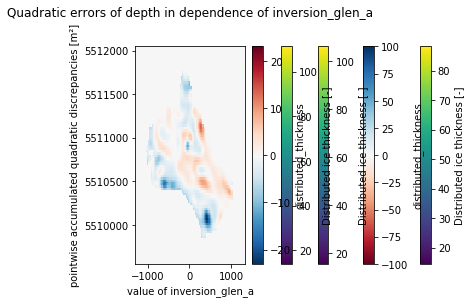

2019-12-06 17:31:59: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 10.753381502574385 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.12000000000000001
smoothing window (m): 101.0


2019-12-06 17:32:02: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:32:02: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:32:02: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:32:02: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:32:02: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:32:02: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:32:02: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:32:03: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:32:03: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:32:03

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:32:05: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:32:05: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:32:06: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:32:09: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:32:09: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:32:09: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:32:09: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:32:09: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:32:09: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:32:09: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:32:10: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:32:12: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:32:12: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:32:12: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:32:14: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:32:15: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:32:15: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:32:16: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:32:16: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:32:16: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:32:16: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:32:16: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:32:16: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:32:18: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:32:18: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:32:19: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:32:21: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:32:22: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:32:22: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:32:23: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:32:23: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:32:23: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:32:23: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:32:23: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:32:23: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:32:25: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:32:25: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.02068081366592338
corrected quadratic error is:  75517.13656326385
ME: 0.8537628122044904
MAE: 10.31765775551084


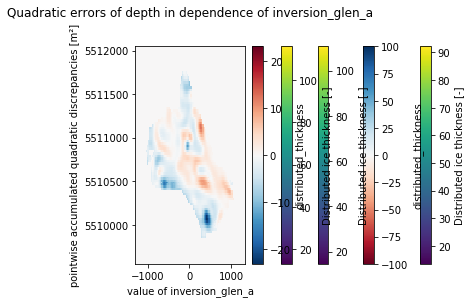

2019-12-06 17:32:26: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 10.31765775551084 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.17
smoothing window (m): 101.0


2019-12-06 17:32:28: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:32:28: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:32:29: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:32:29: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:32:29: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:32:29: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:32:29: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:32:29: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:32:30: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:32:30

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:32:32: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:32:32: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:32:33: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:32:35: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:32:35: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:32:35: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:32:35: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:32:35: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:32:35: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:32:35: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:32:36: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:32:38: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:32:38: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:32:38: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:32:40: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:32:41: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:32:42: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:32:42: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:32:42: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:32:42: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:32:43: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:32:43: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:32:43: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:32:45: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:32:45: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:32:46: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:32:47: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:32:48: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:32:49: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:32:49: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:32:50: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:32:50: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:32:50: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:32:50: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:32:50: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:32:52: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:32:52: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.021644755177086437
corrected quadratic error is:  72082.98659839667
ME: 0.5266357935391939
MAE: 10.080126121572778


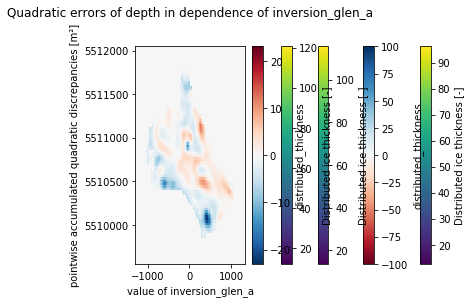

2019-12-06 17:32:53: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 10.080126121572778 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.22000000000000003
smoothing window (m): 101.0


2019-12-06 17:32:56: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:32:56: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:32:56: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:32:56: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:32:56: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:32:56: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:32:56: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:32:56: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:32:57: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:32:57

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:32:59: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:32:59: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:33:00: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:33:02: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:33:02: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:33:02: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:33:02: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:33:02: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:33:02: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:33:02: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:33:03: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:33:05: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:33:05: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:33:06: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:33:07: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:33:09: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:33:09: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:33:09: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:33:10: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:33:10: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:33:10: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:33:10: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:33:10: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:33:12: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:33:12: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:33:13: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:33:14: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:33:15: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:33:15: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:33:16: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:33:16: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:33:16: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:33:16: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:33:16: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:33:16: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:33:19: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:33:19: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.022012426532272603
corrected quadratic error is:  70852.35497422518
ME: 0.21068951015558718
MAE: 10.021359033714052


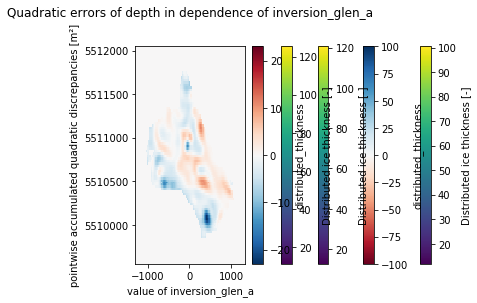

2019-12-06 17:33:20: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 10.021359033714052 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.27
smoothing window (m): 101.0


2019-12-06 17:33:23: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:33:23: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:33:23: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:33:23: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:33:23: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:33:23: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:33:23: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:33:24: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:33:24: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:33:24

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:33:26: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:33:26: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:33:26: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:33:29: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:33:29: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:33:29: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:33:29: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:33:29: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:33:29: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:33:30: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:33:30: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:33:32: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:33:32: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:33:32: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:33:34: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:33:35: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:33:35: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:33:36: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:33:36: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:33:36: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:33:36: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:33:36: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:33:36: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:33:39: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:33:39: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:33:39: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:33:41: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:33:42: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:33:42: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:33:43: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:33:43: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:33:43: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:33:43: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:33:43: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:33:43: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:33:46: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:33:46: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.021729919104605012
corrected quadratic error is:  71794.22877006808
ME: -0.09427374412571143
MAE: 10.088321098914513


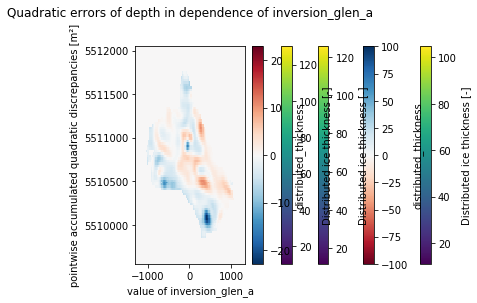

2019-12-06 17:33:46: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 10.088321098914513 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.32
smoothing window (m): 101.0


2019-12-06 17:33:49: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:33:49: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:33:49: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:33:49: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:33:49: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:33:49: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:33:49: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:33:50: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:33:50: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:33:50

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:33:52: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:33:52: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:33:52: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:33:55: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:33:55: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:33:55: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:33:55: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:33:55: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:33:55: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:33:55: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:33:56: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:33:58: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:33:58: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:33:58: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:34:00: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:34:01: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:34:01: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:34:02: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:34:02: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:34:02: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:34:02: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:34:02: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:34:02: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:34:05: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:34:05: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:34:06: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:34:07: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:34:08: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:34:08: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:34:09: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:34:09: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:34:09: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:34:09: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:34:09: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:34:09: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:34:12: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:34:12: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.020856053079889376
corrected quadratic error is:  74869.21725878255
ME: -0.3885062355800991
MAE: 10.314307340130007


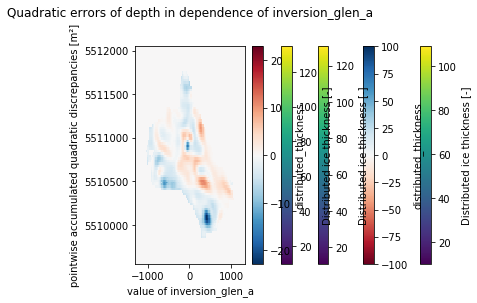

2019-12-06 17:34:12: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 10.314307340130007 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.37000000000000005
smoothing window (m): 101.0


2019-12-06 17:34:15: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:34:16: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:34:16: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:34:16: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:34:16: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:34:16: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:34:16: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:34:16: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:34:16: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:34:17

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:34:18: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:34:18: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:34:19: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:34:21: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:34:21: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:34:21: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:34:21: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:34:22: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:34:22: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:34:22: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:34:22: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:34:25: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:34:25: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:34:25: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:34:27: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:34:28: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:34:28: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:34:28: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:34:28: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:34:28: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:34:28: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:34:28: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:34:29: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:34:31: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:34:31: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:34:32: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:34:33: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:34:35: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:34:35: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:34:35: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:34:35: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:34:35: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:34:36: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:34:36: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:34:36: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:34:39: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:34:39: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.01953725842290429
corrected quadratic error is:  80030.65041320109
ME: -0.6723039829892811
MAE: 10.723904741295861


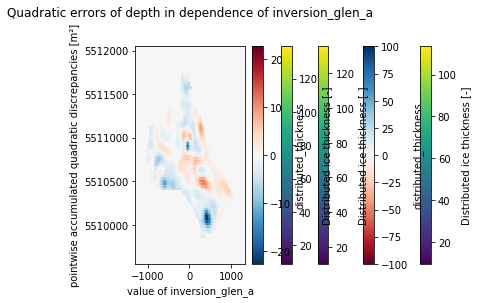

2019-12-06 17:34:39: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 10.723904741295861 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.42000000000000004
smoothing window (m): 101.0


2019-12-06 17:34:42: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:34:42: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:34:42: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:34:42: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:34:42: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:34:42: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:34:42: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:34:43: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:34:43: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:34:43

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:34:45: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:34:45: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:34:45: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:34:48: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:34:48: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:34:48: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:34:48: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:34:48: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:34:48: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:34:49: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:34:49: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:34:51: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:34:51: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:34:52: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:34:54: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:34:55: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:34:55: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:34:55: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:34:56: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:34:56: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:34:56: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:34:56: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:34:56: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:34:58: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:34:58: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:34:59: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:35:00: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:35:02: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:35:02: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:35:02: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:35:03: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:03: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:03: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:03: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:03: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:35:06: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:06: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.017954619829223
corrected quadratic error is:  87225.65027526343
ME: -0.9460024531610411
MAE: 11.27015420861913


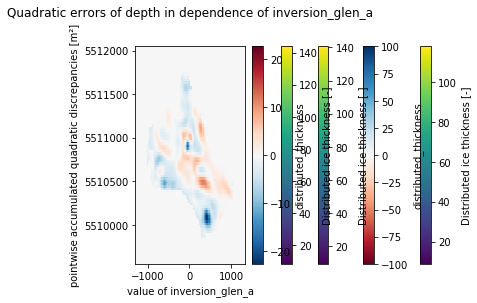

2019-12-06 17:35:06: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 11.27015420861913 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.47000000000000003
smoothing window (m): 101.0


2019-12-06 17:35:09: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:35:09: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:35:09: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:09: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:09: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:09: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:09: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:35:09: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:35:10: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:35:10

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:35:12: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:12: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:35:12: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:35:15: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:35:15: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:35:16: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:16: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:16: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:16: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:16: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:35:16: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:35:18: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:18: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:35:18: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:35:19: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:35:20: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:35:20: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:35:20: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:35:20: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:20: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:21: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:21: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:21: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:35:22: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:22: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:35:23: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:35:24: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:35:25: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:35:25: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:35:26: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:35:26: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:26: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:26: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:26: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:26: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:35:28: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:28: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.01627432576121099
corrected quadratic error is:  96396.19109067791
ME: -1.209967885082124
MAE: 11.902902814597565


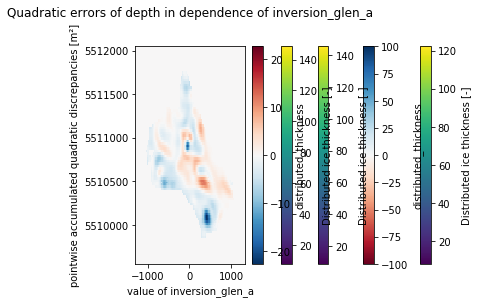

2019-12-06 17:35:28: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 11.902902814597565 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.52
smoothing window (m): 101.0


2019-12-06 17:35:30: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:35:31: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:35:31: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:31: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:31: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:31: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:31: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:35:31: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:35:31: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:35:31

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:35:33: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:33: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:35:33: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:35:35: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:35:35: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:35:35: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:35: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:35: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:35: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:35: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:35:36: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:35:37: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:37: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:35:37: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:35:38: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:35:40: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:35:40: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:35:40: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:35:40: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:40: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:40: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:40: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:40: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:35:42: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:42: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:35:43: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:35:44: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:35:45: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:35:45: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:35:45: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:35:45: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:45: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:45: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:45: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:45: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:35:47: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:47: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.014620568385700184
corrected quadratic error is:  107480.11167342795
ME: -1.4645908536954164
MAE: 12.579323138586537


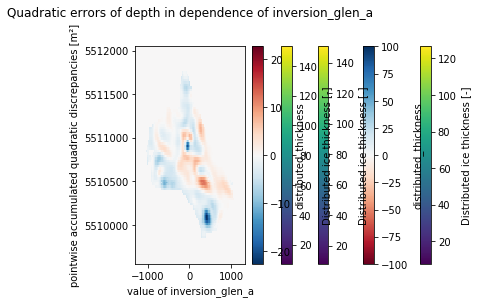

2019-12-06 17:35:48: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 12.579323138586537 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.5700000000000001
smoothing window (m): 101.0


2019-12-06 17:35:50: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:35:50: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:35:50: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:50: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:50: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:50: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:50: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:35:50: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:35:51: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:35:51

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:35:52: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:52: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:35:52: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:35:54: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:35:54: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:35:54: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:54: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:54: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:54: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:54: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:35:55: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:35:56: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:35:56: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:35:56: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:35:58: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:35:59: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:35:59: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:35:59: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:35:59: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:35:59: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:35:59: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:35:59: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:35:59: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:36:01: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:01: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:01: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:36:02: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:36:03: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:36:03: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:36:04: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:36:04: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:04: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:04: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:04: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:04: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:36:06: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:06: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.013070882836803676
corrected quadratic error is:  120412.03966344883
ME: -1.710278927470764
MAE: 13.309379299301908


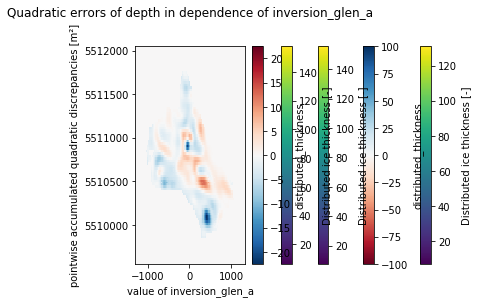

2019-12-06 17:36:06: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 13.309379299301908 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.6200000000000001
smoothing window (m): 101.0


2019-12-06 17:36:08: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:36:08: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:36:09: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:09: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:09: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:09: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:09: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:36:09: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:36:09: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:36:09

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:36:10: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:11: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:11: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:36:13: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:36:13: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:36:13: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:13: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:13: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:13: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:13: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:36:13: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:36:15: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:15: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:36:15: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:16: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:36:17: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:36:17: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:36:18: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:36:18: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:18: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:18: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:18: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:18: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:36:20: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:20: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:20: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:36:21: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:36:22: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:36:22: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:36:23: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:36:23: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:23: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:23: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:23: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:23: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:36:25: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:25: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.01166433305998679
corrected quadratic error is:  135124.29132685895
ME: -1.9474518029398509
MAE: 14.071281355430637


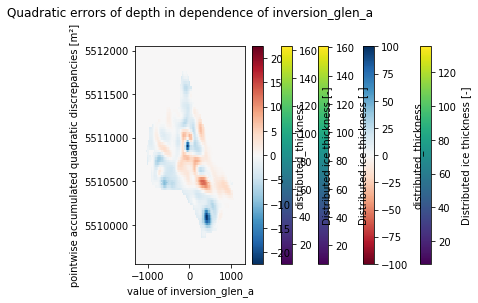

2019-12-06 17:36:25: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 14.071281355430637 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.6700000000000002
smoothing window (m): 101.0


2019-12-06 17:36:27: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:36:27: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:36:27: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:27: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:27: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:27: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:28: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:36:28: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:36:28: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:36:28

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:36:30: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:30: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:30: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:36:32: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:36:32: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:36:32: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:32: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:32: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:32: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:32: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:36:32: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:36:34: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:34: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:36:34: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:35: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:36:36: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:36:36: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:36:37: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:36:37: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:37: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:37: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:37: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:37: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:36:39: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:39: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:39: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:36:40: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:36:41: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:36:41: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:36:42: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:36:42: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:42: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:42: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:42: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:42: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:36:44: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:44: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.01041342175792568
corrected quadratic error is:  151547.65156404648
ME: -2.176535634433522
MAE: 14.878067868867072


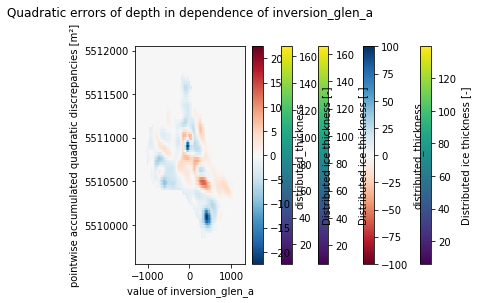

2019-12-06 17:36:44: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 14.878067868867072 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.72
smoothing window (m): 101.0


2019-12-06 17:36:46: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:36:46: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:36:46: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:46: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:46: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:46: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:46: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:36:47: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:36:47: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:36:47

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:36:48: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:48: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:48: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:36:50: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:36:51: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:36:51: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:51: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:51: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:51: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:51: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:36:51: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:36:53: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:53: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:36:53: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:54: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:36:55: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:36:55: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:36:55: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:36:55: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:36:55: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:36:55: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:36:55: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:36:55: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:36:57: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:36:57: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:36:58: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:36:59: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:37:00: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:37:00: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:00: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:37:00: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:00: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:00: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:00: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:01: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:37:02: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:02: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.009314675454881105
corrected quadratic error is:  169612.11696502016
ME: -2.397957526720487
MAE: 15.705878166052011


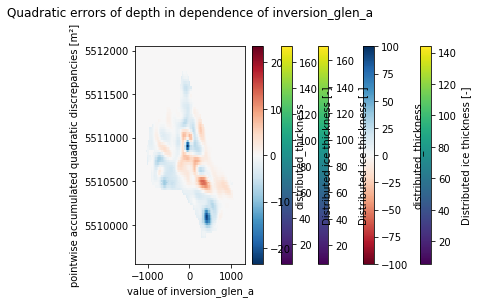

2019-12-06 17:37:03: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 15.705878166052011 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.77
smoothing window (m): 101.0


2019-12-06 17:37:05: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:37:05: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:37:05: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:05: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:05: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:05: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:05: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:37:06: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:06: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:37:06

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:37:07: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:07: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:37:07: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:37:09: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:37:09: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:37:09: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:09: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:09: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:09: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:10: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:37:10: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:37:11: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:11: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:37:12: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:37:13: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:37:14: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:37:14: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:14: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:37:14: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:14: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:14: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:14: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:14: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:37:16: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:16: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:37:17: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:37:18: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:37:19: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:37:19: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:19: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:37:19: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:19: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:19: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:19: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:19: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:37:21: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:21: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.008356303773908587
corrected quadratic error is:  189247.56873552644
ME: -2.612142603861261
MAE: 16.57425517302293


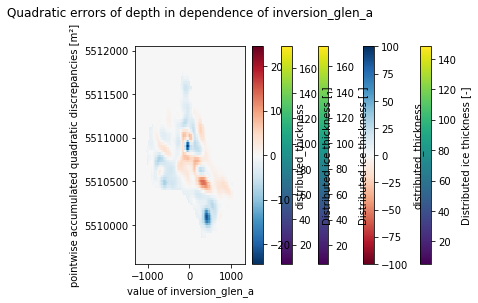

2019-12-06 17:37:22: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 16.57425517302293 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.8200000000000001
smoothing window (m): 101.0


2019-12-06 17:37:24: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:37:24: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:37:24: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:24: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:24: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:24: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:24: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:37:24: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:24: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:37:25

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:37:26: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:26: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:37:26: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:37:28: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:37:28: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:37:28: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:28: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:28: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:28: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:28: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:37:29: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:37:30: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:30: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:37:30: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:37:31: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:37:32: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:37:33: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:33: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:37:33: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:33: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:33: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:33: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:33: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:37:35: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:35: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:37:35: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:37:36: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:37:37: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:37:38: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:38: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:37:38: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:38: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:38: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:38: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:38: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:37:40: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:40: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.007523086740156046
corrected quadratic error is:  210384.24637682104
ME: -2.8195095785063318
MAE: 17.44996162453388


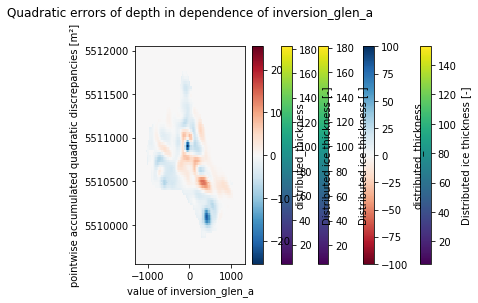

2019-12-06 17:37:40: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 17.44996162453388 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.8700000000000001
smoothing window (m): 101.0


2019-12-06 17:37:43: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:37:43: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:37:43: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:43: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:43: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:43: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:43: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:37:43: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:43: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:37:43

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:37:45: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:45: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:37:45: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:37:47: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:37:47: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:37:47: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:47: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:47: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:47: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:47: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:37:48: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:37:49: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:49: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:37:49: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:37:50: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:37:51: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:37:52: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:52: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:37:52: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:52: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:52: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:52: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:52: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:37:54: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:54: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:37:55: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:37:56: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:37:57: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:37:57: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:37:57: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:37:57: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:37:57: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:37:57: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:37:57: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:37:57: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:37:59: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:37:59: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.006799188770834434
corrected quadratic error is:  232953.28516240636
ME: -3.020466796952675
MAE: 18.32601712839636


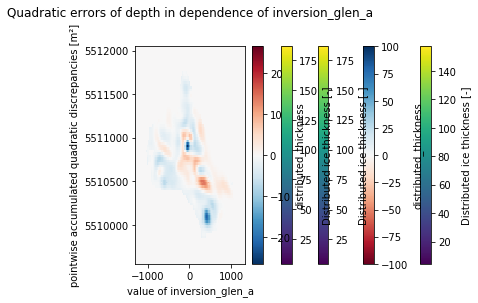

2019-12-06 17:38:00: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 18.32601712839636 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.9200000000000002
smoothing window (m): 101.0


2019-12-06 17:38:02: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:38:02: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:38:02: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:38:02: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:38:02: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:38:02: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:38:02: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:38:02: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:38:02: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:38:03

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:38:04: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:38:04: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:38:04: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg
2019-12-06 17:38:06: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:38:06: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:38:07: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:38:07: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:38:07: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:38:07: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:38:07: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:38:07: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instea

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:38:09: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:38:09: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2019-12-06 17:38:09: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:38:10: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:38:11: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:38:11: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:38:11: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:38:12: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:38:12: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:38:12: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:38:12: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:38:12: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:38:14: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:38:14: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



2019-12-06 17:38:14: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Fantanstic, both arrays have the same shape of:  (66, 73)


2019-12-06 17:38:15: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20160913_kokanee_dem1_clip_slave.tif


2019-12-06 17:38:16: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2019-12-06 17:38:16: oggm.workflow: Multiprocessing: using all available processors (N=8)
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:38:17: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/core/gis.py:505: RuntimeWarning: invalid value encountered in less_equal
  topo[topo <= -999.] = np.NaN
2019-12-06 17:38:17: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:38:17: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:38:17: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:38:17: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:38:17: ogg

slope: 0.247017    intercept: 2632.342082   R-squared: 0.999211


2019-12-06 17:38:19: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:38:19: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2577.465818848402, 'grad': 6.84}
slope default: 0.247017    intercept: 2632.342082   R-squared: 0.999211
slope: 0.146199    intercept: 2577.465819   R-squared: 1.000000
<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)

found  2  problem(s) within a total number of data point of:  442  problem share  0.006169625680475271
corrected quadratic error is:  256887.11597489167
ME: -3.215411568119515
MAE: 19.207140855659727


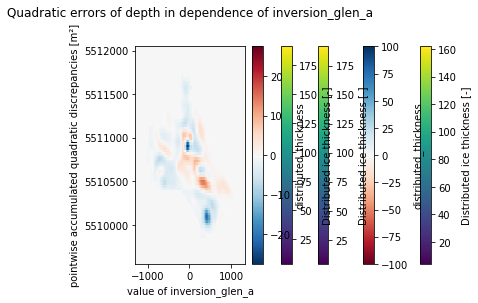

2019-12-06 17:38:19: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/oggm/params.cfg


Minimal value is 19.207140855659727 at inversion_glen_a = 4.84e-24
obs grid cells count: 442
dfb exponent:         0.97
smoothing window (m): 101.0


2019-12-06 17:38:22: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-12-06 17:38:22: oggm.workflow: Multiprocessing: using all available processors (N=8)
2019-12-06 17:38:22: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-12-06 17:38:22: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2019-12-06 17:38:22: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2019-12-06 17:38:22: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers
2019-12-06 17:38:22: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2019-12-06 17:38:22: oggm.workflow: Execute entity task catchment_intersections on 1 glaciers
/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
2019-12-06 17:38:22: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2019-12-06 17:38:23

slope: 0.247004    intercept: 2636.970523   R-squared: 0.999427


2019-12-06 17:38:24: oggm.workflow: Execute entity task apparent_mb_from_linear_mb on 1 glaciers
2019-12-06 17:38:24: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


{'ela_h': 2582.492811418884, 'grad': 6.84}
slope default: 0.247004    intercept: 2636.970523   R-squared: 0.999427
slope: 0.146199    intercept: 2582.492811   R-squared: 1.000000
parameter value: 4.84e-24

glacier total volume: rgi_id
RGI60-02.00147    0.0756
Name: inv_volume_km3, dtype: float64 km^3 
 
 

mean thickness value: 49.33558991509936 m 

<oggm.GlacierDirectory>
  RGI id: RGI60-02.00147
  Region: 02: Western Canada and US
  Subregion: 02-03: N Rocky Mtns                    
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 1.8 km2
  Lon, Lat: (-117.13702323477436, 49.7490063376536)
  Grid (nx, ny): (91, 86)
  Grid (dx, dy): (29.0, -29.0)



[11.333442068747265,
 10.753381502574385,
 10.31765775551084,
 10.080126121572778,
 10.021359033714052,
 10.088321098914513,
 10.314307340130007,
 10.723904741295861,
 11.27015420861913,
 11.902902814597565,
 12.579323138586537,
 13.309379299301908,
 14.071281355430637,
 14.878067868867072,
 15.705878166052011,
 16.57425517302293,
 17.44996162453388,
 18.32601712839636,
 19.207140855659727]

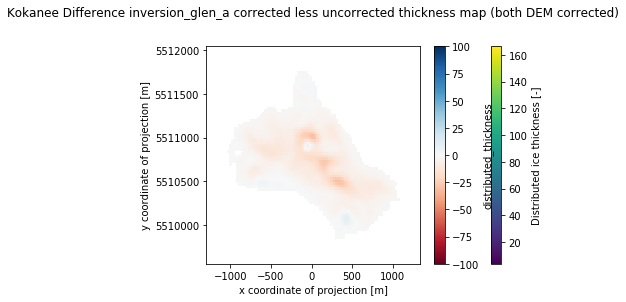

In [14]:
for i in dfb:
    DFB=dfb[count]
    def new_mb_grad_corr_dem(num, dem, glacier, name, parameter, best, use_dem_corr):
        """
        :param num: number of selected glacier
        :param dem: list with dem file names
        :param glacier: the list with the glacier names
        :param name: name of the parameter to be modified
        :param parameter: value of the parameter to be modified
        :param best: if TRUE, an extra save with prefix 'best' will be created
        :param use_dem_correction: if TRUE, a Lidar DEM correction will be used
        :type num: int
        :type dem: str list
        :type glacier: str list
        :type name: str 
        :type parameter: float
        :type best: boolean
        :type use_dem_correction: boolean
        :returns: distributed thickness
        :rtype: 2D float array
        """
        # Initialize OGGM and set up the run parameters --> Read the configuration file containing the run’s parameters.
        cfg.initialize(logging_level='WORKFLOW')

        #num determines which gdir and gradient to use, refer to list below to select desired site
        grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1


        # Get the RGI glaciers for the run.
        rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688', 'RGI60-02.04264', 'RGI60-02.07780']
        rgidf = utils.get_rgi_glacier_entities([rgi_list[num]])


        ############################################################# here the DEM correction happens #########################################################

        if(use_dem_corr==True):

            custom_dem_path = '/home/pelto/Desktop/lidar_cbt_analysis/' + dem[num] #glacier_lower[num]
            print(custom_dem_path)
            WORKING_DIR2 = utils.gettempdir(glacier[num] + '_SR_lidar_dem') # Let's make a working directory for this DEM 
            utils.mkdir(WORKING_DIR2, reset=True)
            cfg.initialize(logging_level='WORKFLOW')
            cfg.PATHS['working_dir'] = WORKING_DIR2

            cfg.PATHS['dem_file'] = custom_dem_path
            rgidf['DEM_SOURCE'] = 'USER'
            cfg.PARAMS['use_intersects'] = True

            cfg.PARAMS['smooth_window'] = sw
    #         cfg.PARAMS['grid_dx_method'] = 'fixed'
    #         cfg.PARAMS['fixed_dx'] = dx[num]
            if glacier[num] == 'Nordic' or 'Washmawapta':
                cfg.PARAMS['use_intersects'] = False

    #         gdirs = workflow.init_glacier_regions(rgidf)
            cfg.PARAMS['use_rgi_area'] = False

        else:
            cfg.PARAMS['use_intersects'] = True
            if glacier[num] == 'Nordic' or 'Washmawapta':
                cfg.PARAMS['use_intersects'] = False
            cfg.PARAMS['border'] = 10
            cfg.PATHS['working_dir'] = utils.get_temp_dir('_SR_thick_srtm' + glacier[num])
            cfg.PARAMS['use_rgi_area'] = False
            cfg.PARAMS[name] = parameter
            cfg.PARAMS['smooth_window'] = sw

        ###########################################################################################################################

        cfg.PARAMS[name] = parameter
        cfg.PARAMS['border'] = 10

        temporarily = [rgi_list[num]]
        rgidf = utils.get_rgi_glacier_entities(temporarily)#[rgi_list[num]]) !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        gdirs = workflow.init_glacier_regions(rgidf)
        workflow.gis_prepro_tasks(gdirs)
        workflow.climate_tasks(gdirs)
        workflow.inversion_tasks(gdirs)
        workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs, dis_from_border_exp=DFB);

        gdir = gdirs[0]
        tasks.init_present_time_glacier(gdir) ##This updates the mode_flowlines file and creates a stand-alone numerical glacier ready to run.

        # Print the standard MB gradient from OGGM default
        from oggm.core.massbalance import ConstantMassBalance, MultipleFlowlineMassBalance
        # gdir = gdirs[num]

        mb_mod = MultipleFlowlineMassBalance(gdir, use_inversion_flowlines=True, mb_model_class=ConstantMassBalance)
        z, w, mb_on_z = mb_mod.get_annual_mb_on_flowlines()
        mb_on_z *=  cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

        # grad_line = np.polyfit(mb_on_z,z,2)
        from scipy import stats 
        slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
        print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

        # See the result of the inversion
        workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs, dis_from_border_exp=DFB);

        ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
        ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)

        ds_default = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
        ds_default.close() # I have the strange feeling that xarray sometimes won't re-read overwitten files (and we will overwrite it later)


        # Let's apply a linear MB instead
        from oggm.core.climate import apparent_mb_from_linear_mb


        workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdir, mb_gradient=grad[num]);

        from oggm.core.massbalance import LinearMassBalance

        params = gdir.read_pickle('linear_mb_params')
        print(params)

        l_mb_mod = LinearMassBalance(params['ela_h'], grad=params['grad'])
        l_mb_on_z = l_mb_mod.get_annual_mb(z) * cfg.PARAMS['ice_density'] * cfg.SEC_IN_YEAR

        slope, intercept, r_value, p_value, std_err = stats.linregress(mb_on_z, z)
        print("slope default: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)
        slope, intercept, r_value, p_value, std_err = stats.linregress(l_mb_on_z, z)
        print("slope: %f    intercept: %f" % (slope, intercept), "  R-squared: %f" % r_value**2)

        ds_new = xr.open_dataset(gdir.get_filepath('gridded_data')).load()
        ds_new.close() 


        ########### gather more detailed information about the glacier ##############
        df  = utils.compile_glacier_statistics(gdirs, inversion_only=True)
        volume=df['inv_volume_km3']

        mfl=gdir.read_pickle('model_flowlines')
        thickness= mfl[-1].surface_h - mfl[-1].bed_h
        thickness=thickness[thickness>0].mean()

        ############## write it into txt file: #################

        if(best):
            file= open(products+'best_dem_corr_run_of_'+glacier[num]+'_with_modified_' + name + '.txt', mode='w')
            print('parameter value: '+str(parameter)+'\n')
            print('glacier total volume: '+str(volume)+' km^3 \n \n \n')
            print('mean thickness value: '+str(thickness)+' m \n')
        else:
            file= open(products+'dem_corr_run_of_'+glacier[num]+'_with_modified_' + name+'.txt', mode='w')

        file.writelines(['Run of the DEM corrected model on ' + glacier[num]+' on ', str(datetime.datetime.now()), '\n'])
        file.write('parameter modified: '+name+'\n')
        file.write('parameter value: '+str(parameter)+'\n')
        file.write('glacier total volume: '+str(volume)+' km^3 \n \n \n')
        file.write('mean thickness value: '+str(thickness)+' m \n')
    #     file.write('Minimal value is '+str(np.min(to_plot[1]))+ ' at ' + parameter_name+' = ' +str(np.round(to_plot[0][x],decimals=28)))
        file.close()
        ##########################################################
        print(gdir)
        return ds_new.distributed_thickness

    ## Comparing DEM-corrected model with non-DEM-corrected model:

#     - first we run the 'new_mb_grad' function
#     - then we run the 'new_mb_grad_corr_dem' function
#     - and then we subtract the thickness maps and can see where the usage of Lidar data actually impacted the outcome of the model

    # run the model without DEM correction
    new_mb_gradient= new_mb_grad_corr_dem(num, dem, glacier, 'ice_density', 900, False, False)

    # plot it as a map
    new_mb_gradient.plot()
    plt.title(glacier[num]+' standard settings thickness map')
    # and save it
    plt.savefig('/home/pelto/Desktop/ice_thick/products'+'standard_map_'+ glacier[num]+'.png', dpi=100)

    # replace 'nan' by  0
    new_mb_gradient=new_mb_gradient.fillna(0)

    if glacier[num]=='Washmawapta':
        # make a copy for comparison reasons later on
        new_mb_gradient_corr_dem=new_mb_gradient

    # run the model with DEM correction
    new_mb_gradient_corr_dem = new_mb_grad_corr_dem(num, dem, glacier, 'ice_density', 900, False, True)

    # plot it as a map
    new_mb_gradient_corr_dem.plot()
    plt.title(glacier[num]+' DEM corrected Thickness map')

    # and save it
    plt.savefig(products+'dem_corr_standard_map_'+ glacier[num]+'.png', dpi=100)

    # replace 'nan' by  0
    new_mb_gradient_corr_dem=new_mb_gradient_corr_dem.fillna(0)

    # make a copy for comparison reasons later on
    new_mb_gradient_corr_dem_copy=new_mb_gradient_corr_dem

    # the actual differencing and plotting
    (new_mb_gradient_corr_dem-new_mb_gradient).plot()

    # label it, save it
    plt.title(glacier[num]+' Difference DEM corrected tickness less standard DEM')
    plt.savefig(products+'difference_dem_correction_'+ glacier[num]+'.png', dpi=100)

    ## Parameter optimization

#     We want to run the Model with different values for a certain parameter. Therefore we define a few functions that will iterate over a sequenze of paramter values and allow us to compare the outcome to the observation data by displaying their respective squared residuals

    def run_with_parameter(num,dem, glacier, name, parameter):
        """
        :param num: number of selected glacier
        :param dem: list with dem file names
        :param glacier: the list with the glacier names
        :param name: name of the parameter to be modified
        :param parameter: value of the parameter to be modified
        :type num: int
        :type dem: str list
        :type glacier: str list
        :type name: str 
        :type parameter: float
        :returns: distributed thickness
        :rtype: 2D float array
        """

        # just to be 100% sure, we are setting the most common parameters to their presettings in order to only vary the desired parameter
        cfg.PARAMS['smooth_window'] = sw
        cfg.PARAMS['ice_density'] = 900
        cfg.PARAMS['trapezoid_lambdas'] = 0.2
        cfg.PARAMS['mixed_min_shape'] = 0.001
        cfg.PARAMS['downstream_min_shape'] = 0.0001
        cfg.PARAMS['mu_star_halfperiod'] = 15
        cfg.PARAMS['tstar_search_glacierwide'] = False
        cfg.PARAMS['border'] = 10
        cfg.PARAMS['glen_a'] = 2.4e-24
        cfg.PARAMS['inversion_glen_a'] = 2.4e-24
        cfg.PARAMS['default_parabolic_bedshape'] = 0.003
        cfg.PARAMS['use_shape_factor_for_fluxbasedmodel'] = ''

        #change the parameter (not sure, whether it has any effect here...)
        cfg.PARAMS[name] = parameter

        # run the model (in this case with DEM correction)
        outcome=new_mb_grad_corr_dem(num, dem, glacier, name, parameter, False, True).fillna(0)

        #return the thickness distribution
        return outcome

    ## Definitions


    # deletes the rows and lines that do only carry zeros for the sake of getting the right resolution 
    # in order to rasterize the observation data to the same resolution and getting perfectly fitting arrays
    def delete_nodata(data):
        """
        :param data: distributed thickness with 'nan' or '0' in it
        :type data: 2D floar array
        :returns: distributed thickness
        :rtype: 2D float array
        """

        # get a numpy array out of it
        data=data.values

        #get the spots were actual values are
        coordinates=np.nonzero(data)

        # create a fresh array of the minimal shape to contain all non-zero values
        result=np.zeros(((1+np.max(coordinates[0])-np.min(coordinates[0])) ,(1+np.max(coordinates[1])-np.min(coordinates[1]))))

        # fill it with the values
        for i in range(0, len(coordinates[0])):
            result[coordinates[0][i]-np.min(coordinates[0])][coordinates[1][i]-np.min(coordinates[1])]=data[coordinates[0][i]][coordinates[1][i]]

        # flip it and rotate it by pi
        return np.flip(np.rot90(result,2))

    # a simple function to open the observation data and return it as an array
    def read_obs_data(path):
        """
        :param path: distributed thickness with 'nan' or '0' in it
        :type path: str
        :returns: measurement points as an array
        :rtype: 2D float array
        """
        src_obs = gdal.Open(path)
        return src_obs.ReadAsArray()

    ## Data Import

    # We open the observation data for the respective glacier and print out the shape and compare it with the shape of the OGGM:

    obs_data = read_obs_data('/home/pelto/oggm_runs/OGGM/MONSTER_project/MONSTER/obs_data_' + glacier[num] + '.tif')

    if obs_data.shape == delete_nodata(new_mb_gradient_corr_dem).shape:
        print('Fantanstic, both arrays have the same shape of: ' ,obs_data.shape )
    else:
        print('Oh, Oh! Something went wrong because the observation data has the shape ' ,obs_data.shape , ' and the OGGM out put has a shape of: ' ,delete_nodata(new_mb_gradient_corr_dem).shape )


    # Layover-Control

#     This is a checking tool for adjusting the orientation of the observation data with respect to the model shapefile (in order to make it fit, we had to flip and rotate it in the 'delete_nodata' function). The resolution is not great but is should give an optical feedback on the fit. 

    # run the delete_nodata function on one of the recent outputs and save it in a temporay variable
    temp=delete_nodata(new_mb_gradient_corr_dem)

    # get its shape
    h,w = temp.shape

    # create a new array with zeros and of same size
    data = np.zeros((h, w, 3), dtype=np.uint8)

    # and get the data point coordinates
    nonzero=np.nonzero(temp)

    # run through the OGGM output and write into the array as RED color code
    for i in range(0,len(nonzero[0])):
        data[nonzero[0][i]][nonzero[1][i]]= [temp[nonzero[0][i]][nonzero[1][i]], 0, 0]

    # run through the observation data and write into the array as GREEN color code
    for i in range(0,len(np.nonzero(obs_data)[0])):
        data[np.nonzero(obs_data)[0][i]][np.nonzero(obs_data)[1][i]]= [0, obs_data[np.nonzero(obs_data)[0][i]][np.nonzero(obs_data)[1][i]], 0]

    # save and show
    img = imagery.fromarray(data, 'RGB')
    img.save(products+ 'overlay_test_'+ glacier[num]+ '.png')

    from IPython.display import Image
    Image(filename=products+'overlay_test_'+ glacier[num]+ '.png', width=400) 

    def quadratic_errors(obs_data, mesharray):
        """
        :param obs_data: array with measured values on respective spots
        :param mesharray: distributed thickness of the model output (should have same shape as obs_data)
        :type obs_data: 2D float array
        :type mesharray: 2D float array
        :returns: quadrativc error (problems corrected)
        :rtype: float
        """

        # counts number of "problematic" pixels
        count=0

        # coordinates of the data points
        coordinates=np.nonzero(obs_data)

        # accumulated 'problematic pixel' quadratic error
        problems=0
        prob=0 #problems per grid cell summed
        # total accumulated quadratic error
        err=0
        ME=0
        MAE=0

        # we go through all the measured points and accumulate the squared differences to the OGGM at that point
        for i in range(0,len(coordinates[0])):

            # if however, the OGGM shows a thickness of zero there, this seems to be a "problematic" pixel 
            if mesharray[coordinates[0][i]][coordinates[1][i]]==0:

                # add to problems share
                problems=problems+obs_data[coordinates[0][i]][coordinates[1][i]]**2
                prob=(prob+obs_data[coordinates[0][i]][coordinates[1][i]])

                # increment problem number
                count=count+1

            # add squared difference
            err=err+(obs_data[coordinates[0][i]][coordinates[1][i]]-mesharray[coordinates[0][i]][coordinates[1][i]])**2

            ##add mean error and mean absolute error
            ME=ME+(obs_data[coordinates[0][i]][coordinates[1][i]]-mesharray[coordinates[0][i]][coordinates[1][i]])
            MAE=MAE+(np.abs((obs_data[coordinates[0][i]][coordinates[1][i]]-mesharray[coordinates[0][i]][coordinates[1][i]])))

        # print of details on "problematic" pixels
        print('found ', count , ' problem(s) within a total number of data point of: ', len(coordinates[0]), ' problem share ', problems/err,)

        ME_final = (ME)/(np.count_nonzero(obs_data))
        MAE_final = (MAE)/(np.count_nonzero(obs_data))
        problems_per = prob / (np.count_nonzero(obs_data)) ##quite small or zero at all sites, but worth evaluating

        print('corrected quadratic error is: ', err-problems)
        print('ME:', ME_final-problems_per)
        print('MAE:', MAE_final-problems_per)

        return (MAE_final-problems_per) ##only return MEA for now

        # a function that runs the (DEM-corrected) OGGM and uses the quadratic_errors function to return the quadratic errors
    def master_analysis(name, parameter, obs_data, glacier, num):
        """
        :param name: name of the parameter to be modified
        :param parameter: value of the parameter to be modified
        :param obs_data: measured data points
        :param glacier: the list with the glacier names
        :param num: number of selected glacier
        :type name: str
        :type parameter: float
        :type obs_data: 2D float array
        :type glacier: str list
        :type num: int
        :returns: quadratic errors
        :rtype: float
        """
        quadmesh= run_with_parameter(num, dem, glacier, name, parameter)
        mesharray = delete_nodata(quadmesh)

        return quadratic_errors(obs_data, mesharray)

    # this function takes in the name of the parameter that is to be modified and a float list of the values for whose the OGGM is 
    # to be run and the quadratic errors to be calculated. It returns an array with those values and their respective quadratic errors
    def optimize(name, values, obs_data, glacier, num):
        """
        :param name: name of the parameter to be modified
        :param values: values of the parameter to be modified
        :param obs_data: measured data points
        :param glacier: the list with the glacier names
        :param num: number of selected glacier
        :type name: str
        :type values: float list
        :type obs_data: 2D float array
        :type glacier: str list
        :type num: int
        :returns: [values, quad_errors]
        :rtype: float array
        """

        # here we store the original parameter value
        temp= cfg.PARAMS[name]

        #an array to store the quadratic errors in
        quad_errors=[]
        for i in range(0,len(values)):
            quad_errors.append(master_analysis(name, values[i], obs_data, glacier, num))

        # and here we reset it to the default value
        cfg.PARAMS[name] = temp

        return [values, quad_errors]

    ## Enter the parameter, interval and number of points that you want to get the quadratic error from 

#     The parameter intervall will be a linearly spaced sequence from min_value to max_value with number_of_steps steps.

#     Also, choose, whether you prefer to run the iteration with the DEM correction. In the most cases it is strongly recommended to do so.
    

    
    parameter_name='inversion_glen_a'
    max_value= best_value
    min_value= best_value
    number_of_steps=1 #10

    use_dem_correction=True

    ## The actual iteration takes place here

#     %%capture supresses the output, which is quite annoying if the OGGM runs several dozen times. But if you want to watch it work, go for it and delete that line.

#     Apart from that, we basically run the optimize function

#     %%capture
    to_plot=optimize(parameter_name,np.linspace(min_value, max_value, number_of_steps), obs_data ,glacier, num)

#     Now, we plot the quadratic errors as a function of the parameter values. We also print out the minimum.

    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 30
    plt.plot(to_plot[0],to_plot[1],linestyle='--', marker='o', color='b')
    plt.xlabel('value of '+parameter_name)
    plt.ylabel('pointwise accumulated quadratic discrepancies [m²]')
    plt.title('Quadratic errors of depth in dependence of ' +parameter_name)

    # save it
    plt.savefig(products+'quadratic_errors_'+parameter_name+'_from_'+str(min_value)+'_to_'+str(max_value)+'_'+ glacier[num]+'.png', dpi=100)

    plt.show()

    #small minimum function
    x=0
    for i in range(0,len(to_plot[1])):
        if to_plot[1][i]==np.min(to_plot[1]):
            x=i

    # print out
    print('Minimal value is '+str(np.min(to_plot[1]))+ ' at ' + parameter_name+' = ' +str(np.round(to_plot[0][x],decimals=28)))

    file= open(products+'best_dem_corr_run_of_'+glacier[num]+ '_quad_errors' + '_smooth_window_' + str(sw) +'.txt', mode='w') #str(sw)

    file.write('Minimal value is '+str(np.min(to_plot[1]))+ ' at ' + parameter_name+' = ' +str(np.round(to_plot[0][x],decimals=28)))
    file.close()
    
    
    errors=np.min(to_plot[1])
    errors_list.append(errors)
   

    print('obs grid cells count:', np.count_nonzero(obs_data))
    print('dfb exponent:        ', dfb[count])
    print('smoothing window (m):', sw)

    ## Deep analysis of best parameter value

#     Enter the value of the given Paramter, that yields a minimum in quadratic errors

    # take the minimum from above
    # best_value=to_plot[0][x]
    # best_value
    # select it manually


#     Now, we run the model with the best parameter value to create seperate saves and a deep analysis

    best_model= new_mb_grad_corr_dem(num, dem, glacier, parameter_name, best_value, True, False)

    best_model.plot()
    plt.title(glacier[num]+' best approximation thickness map ' + parameter_name + ' = ' +str(best_value))
    plt.savefig(products+'dem_corr_best_map_'+ glacier[num]+'.png', dpi=100)
    #best_model=new_mb_gradient_corr_dem.fillna(0)

    # plot and save
    (best_model-new_mb_gradient_corr_dem_copy).plot(cmap='RdBu', vmin=-100, vmax=100)
    plt.title(glacier[num]+' Difference '+ parameter_name+ ' corrected less uncorrected thickness map (both DEM corrected)')
    plt.savefig(products+'difference_'+ parameter_name + '_corrected_vs_uncorrected_'+ glacier[num]+'.png', dpi=100)
    count+=1
    
errors_list

In [16]:
errors_list[:8]


[11.333442068747265,
 10.753381502574385,
 10.31765775551084,
 10.080126121572778,
 10.021359033714052,
 10.088321098914513,
 10.314307340130007,
 10.723904741295861,
 11.27015420861913,
 11.902902814597565,
 12.579323138586537,
 13.309379299301908,
 14.071281355430637,
 14.878067868867072,
 15.705878166052011,
 16.57425517302293,
 17.44996162453388,
 18.32601712839636,
 19.207140855659727]

In [17]:
out_df = pd.DataFrame()
out_df['errors'] = errors_list
out_df['dfb'] = dfb
out_df['error_per_point'] = out_df['errors'] / float(obs_num[num])
out_df['err_m'] = np.sqrt(out_df['error_per_point'])
out_df['perc_err'] = out_df['err_m'] / thick[num] * 100. 
out_df.to_csv(products + glacier[num] + '_DFB_errors' + str(best_value) + '.csv')
# out_df

In [7]:
out_df[:5]

,errors,dfb,error_per_point,err_m,perc_err
0,13.592397,0.00,0.030752,0.175363,0.364579
1,11.609532,0.05,0.026266,0.162068,0.336939
2,10.965793,0.10,0.024809,0.157510,0.327464
3,10.468547,0.15,0.023684,0.153898,0.319954
4,10.150448,0.20,0.022965,0.151541,0.315055


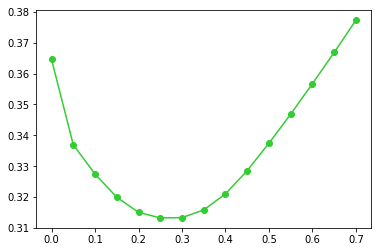

In [8]:
plt.plot(out_df['dfb'], out_df['perc_err'], marker='o', color='limegreen')

In [9]:
# out_df = pd.read_csv('/home/pelto/oggm_runs/products_opt/Conrad/Conrad_DFB_errors.csv')

In [10]:
#small minimum function
x=0
for i in range(0,len(out_df['errors'])):
    if out_df['errors'][i]==np.min(out_df['errors']):
        x=i
print(glacier[num] + ' Minimal value is '+str(np.min(out_df['errors']))+ ' at dfb' + ' = ' +str(np.round(out_df['dfb'][x],decimals=2)))

Kokanee Minimal value is 10.03457757466519 at dfb = 0.25
